In [209]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import json 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import ast
from plotting import *
from sklearn.metrics import f1_score, roc_curve
from pylab import *
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load Data


In [2]:
frames = []
for task in ['binary_abuse', 'binary_movie_sentiment']:
    path = f'../results'
    frames.append(pd.read_csv(f'{path}/{task}/results.csv'))

df = pd.concat(frames, axis = 0, ignore_index=True)

print(df.columns)


Index(['technique', 'model', 'train_runtime', 'n_train', 'n_eval', 'eval_set',
       'balanced_train', 'datetime', 'eval_true', 'eval_pred', 'seed',
       'template', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1',
       'eval_cm (tn, fp, fn, tp)', 'acc', 'f1', 'prec', 'recall', 'task'],
      dtype='object')


# Data Cleaning

In [3]:
print('\n---Pct of NaN in df columns---')
null_cols = []
for c in df.columns:
    num_na = sum(pd.isna(df[c])==True)
    if num_na !=0:
        null_cols.append(c)
    print(f"{c}: {np.round(num_na/len(df[c]),2)}%")

# Remove duplicate columns (correct results stored in ['acc', 'prec', 'recall', 'f1])
# TODO remove these things in processing_results.ipynb before 
drop_cols = ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_cm (tn, fp, fn, tp)']
df = df.drop(drop_cols, axis = 1)


---Pct of NaN in df columns---
technique: 0.0%
model: 0.0%
train_runtime: 0.0%
n_train: 0.0%
n_eval: 0.0%
eval_set: 0.0%
balanced_train: 0.0%
datetime: 0.0%
eval_true: 0.0%
eval_pred: 0.0%
seed: 0.0%
template: 0.32%
eval_accuracy: 0.32%
eval_precision: 0.32%
eval_recall: 0.32%
eval_f1: 0.32%
eval_cm (tn, fp, fn, tp): 0.32%
acc: 0.0%
f1: 0.0%
prec: 0.0%
recall: 0.0%
task: 0.0%


In [4]:
# Model Names
print('\n----MODELS----')
print(f"Original model names:\n{df['model'].value_counts()}")
model_mapping = {'distilbert':'DistilBERT', 'gpt2': 'GPT-2', 
                 'distilbert-base-cased':'DistilBERT',
                 'microsoft/deberta-v3-base':'DeBERTa-v3',
                 'LabelModel': 'LabelModel'}

df['model_name'] = df['model'].map(lambda x: model_mapping[x])

print(f"\nReplaced model names:\n{df['model_name'].value_counts()}")

print(f"\nPer technique model counts:")
for i in df['technique'].unique():
    print(f"\nTechnique: {i}\n{df['model_name'][df['technique']==i].value_counts()}")

# Techniques
print('\n----TECHNIQUES----')
print(f"Original technique names:\n{df['technique'].value_counts()}")

df['technique_name'] = df['technique'].map(lambda x: x.replace('_', " ").title())

print(f"\nReplaced technique names:\n{df['technique_name'].value_counts()}")

# Tasks
print('\n----Tasks----')
print(f"Original task names:\n{df['task'].value_counts()}")

df['task_name'] = df['task'].map(lambda x: x.replace('_', " ").title())

print(f"\nReplaced task names:\n{df['task_name'].value_counts()}")

# Tasks
print('\n----Prompt Templates----')
print(f"Original prompt names:\n{df['template'].value_counts()}")

prompt_dict = {'Binary Abuse': {
                                np.nan:'NAN',
                                '{"placeholder":"text_a"} Is this text abusive? {"mask"}':'Prompt 1: Is this text abusive?',
                                '{"placeholder":"text_a"} Does this text contain abuse? {"mask"}': 'Prompt 2: Does this text contain abuse?',
                                '{"placeholder":"text_a"} It was? {"mask"}' :'Prompt 3: It was? Abusive or Not Abusive'},
                'Binary Movie Sentiment' : {
                                np.nan:'NAN',
                                '{"placeholder":"text_a"} Is this text negative? {"mask"}': 'Prompt 1: Is this text negative?',
                                '{"placeholder":"text_a"} Does this text contain negative sentiment? {"mask"}': 'Prompt 2: Does this text contain negative sentiment?',
                                '{"placeholder":"text_a"} It was? {"mask"}' :'Prompt 3: It was? Negative or Not Negative',}
}


df['template_name'] = df.apply(lambda x: prompt_dict[x['task_name']][x['template']], axis = 1)

print(f"\nReplaced template names:\n{df['template_name'].value_counts()}")




----MODELS----
Original model names:
distilbert                   216
gpt2                         216
distilbert-base-cased         72
microsoft/deberta-v3-base     72
LabelModel                    63
Name: model, dtype: int64

Replaced model names:
DistilBERT    288
GPT-2         216
DeBERTa-v3     72
LabelModel     63
Name: model_name, dtype: int64

Per technique model counts:

Technique: transfer_learning
DistilBERT    72
DeBERTa-v3    72
Name: model_name, dtype: int64

Technique: prompt_engineering
DistilBERT    216
GPT-2         216
Name: model_name, dtype: int64

Technique: weak_supervision
LabelModel    63
Name: model_name, dtype: int64

----TECHNIQUES----
Original technique names:
prompt_engineering    432
transfer_learning     144
weak_supervision       63
Name: technique, dtype: int64

Replaced technique names:
Prompt Engineering    432
Transfer Learning     144
Weak Supervision       63
Name: technique_name, dtype: int64

----Tasks----
Original task names:
binary_abuse    

In [82]:
df['train_runtime'][df['technique_name']=='Transfer Learning'].astype(float).sort_values()

65        0.0000
44        0.0000
67        0.0000
74        0.0000
31        0.0000
         ...    
442     472.7314
445     472.8846
433     996.1687
434     996.2924
469    1000.4479
Name: train_runtime, Length: 144, dtype: float64

In [83]:
# Runtime
from datetime import timedelta, datetime

def timestr_to_float(string):
    if ':' in string:
        t = datetime.strptime(string, '%H:%M:%S.%f').time()
        seconds = int(timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds())
        minutes = seconds/60
         
    else:
        # format already in seconds:
        minutes = float(string)/60

    return minutes


# # TODO: Change to  minutes or hours
df['train_runtime'] = df['train_runtime'].map(lambda x: timestr_to_float(str(x)))



In [84]:
df['train_runtime'].describe()

count    639.000000
mean       1.545439
std        2.654683
min        0.000000
25%        0.114827
50%        0.477733
75%        1.665910
max       16.674132
Name: train_runtime, dtype: float64

In [85]:
# Add experiment ID
experimental_vars = ['technique_name', 'task_name', 'balanced_train', 'template_name','model_name', 'n_train',]

# df['template'] = df['template'].map(lambda x: 'NA' if pd.isna(x)==True else x)
df = df.sort_values(by = experimental_vars)
# Group the data by the experimental variables and create a new column 'experiment_id'
df['seed_id'] = df.groupby(experimental_vars).ngroup().astype(str) + "_" + df['seed'].astype(str)
df['single_experiment_id'] = df['seed_id'].map(lambda x: x.split('_')[0])

print(f"Number of runs per experiment:\n{df['single_experiment_id'].value_counts().value_counts()}")

print(df.columns)

order = ['seed_id', 'single_experiment_id','task', 'task_name', 'technique', 'technique_name', 'model', 'model_name',
         'n_train', 'balanced_train', 'template', 'template_name', 'seed', 'eval_set','eval_true', 'eval_pred',
         'f1', 'acc', 'prec', 'recall', 'train_runtime', 'datetime']

clean_df = df[order].sort_values(by = ['single_experiment_id', 'seed_id'])


# clean_df.to_csv(f'{path}/task_results.csv', index = False)


Number of runs per experiment:
3    213
Name: single_experiment_id, dtype: int64
Index(['technique', 'model', 'train_runtime', 'n_train', 'n_eval', 'eval_set',
       'balanced_train', 'datetime', 'eval_true', 'eval_pred', 'seed',
       'template', 'acc', 'f1', 'prec', 'recall', 'task', 'model_name',
       'technique_name', 'task_name', 'template_name', 'seed_id',
       'single_experiment_id'],
      dtype='object')


# Results Processing Across Seeds and N Train

In [7]:
df = pd.read_csv(f'../results/task_results_v2.csv')
print(df['technique_name'].unique())

['Prompt Engineering' 'Transfer Learning' 'Weak Supervision'
 'Zero Shot Prompt Engineering' 'Naive Bayes']


In [8]:
print(df.columns)
drop_cols = ['task', 'model', 'technique', 'eval_set', 'template']
df = df.drop(drop_cols, axis = 1)
df.columns = [c.replace('_name', '') for c in df.columns]
print(df.columns)
df['template'] = df['template'].map(lambda x: 'NAN' if pd.isna(x)==True else x)

# Groupby experiment id to get results_vars as list across seeds
results_vars = ['eval_true', 'eval_pred', 'f1','acc', 'prec', 'recall', 'train_runtime']
experimental_vars = ['technique',  'task', 'model', 'n_train', 'balanced_train', 'template']

for c in ['eval_pred', 'eval_true']:
    df[c] = df[c].map(lambda x: ast.literal_eval(x))

grp_df = df.groupby('single_experiment_id').agg(lambda x: list(x))
for c in experimental_vars:
    grp_df[c] = grp_df[c].map(lambda x: x[0])

for v in [v for v in results_vars if 'eval' not in v]:
    grp_df[f'{v}_mean'] = grp_df[v].map(lambda x: np.array(x).mean())
    grp_df[f'{v}_std'] = grp_df[v].map(lambda x: np.array(x).std())

fixed_experimental_vars = ['technique',  'task', 'model', 'balanced_train', 'template']

exp_df = grp_df.groupby(fixed_experimental_vars).agg(lambda x: list(x)).reset_index()

Index(['seed_id', 'single_experiment_id', 'task_name', 'technique',
       'technique_name', 'model', 'model_name', 'n_train', 'balanced_train',
       'template', 'template_name', 'seed', 'eval_set', 'eval_true',
       'eval_pred', 'f1', 'acc', 'prec', 'recall', 'train_runtime', 'datetime',
       'task', 'n_eval'],
      dtype='object')
Index(['seed_id', 'single_experiment_id', 'task', 'technique', 'model',
       'n_train', 'balanced_train', 'template', 'seed', 'eval_true',
       'eval_pred', 'f1', 'acc', 'prec', 'recall', 'train_runtime', 'datetime',
       'n_eval'],
      dtype='object')


In [9]:
exp_df

,technique,task,model,balanced_train,template,seed_id,n_train,seed,eval_true,eval_pred,...,f1_mean,f1_std,acc_mean,acc_std,prec_mean,prec_std,recall_mean,recall_std,train_runtime_mean,train_runtime_std
0,Naive Bayes,Binary Abuse,Naive Bayes,False,NAN,"[[231_1, 231_2, 231_3], [232_1, 232_2, 232_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.4684415882, 0.4684415882, 0.4684415882, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7766205879, 0.7766205879, 0.7766205879, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0024805863699999997, 0.0029184023543333336,...","[0.00038309156490678667, 0.0003874803087049083..."
1,Naive Bayes,Binary Abuse,Naive Bayes,True,NAN,"[[238_1, 238_2, 238_3], [239_1, 239_2, 239_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0...",...,"[0.5973843623, 0.577291867, 0.6487237174, 0.70...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.8705272896, 0.8626461843, 0.8783829278, 0.8...","[0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0...","[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.002178748449, 0.0029038588206666666, 0.0042...","[0.0004578276734211458, 0.0002585957218831237,..."
2,Naive Bayes,Binary Movie Sentiment,Naive Bayes,False,NAN,"[[245_1, 245_2, 245_3], [246_1, 246_2, 246_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...","[[[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1...",...,"[0.5569329838, 0.4032471488, 0.6380910956, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.56, 0.5304, 0.6528, 0.5736, 0.7096, 0.7872,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.5617086483, 0.7058201608, 0.682463064099999...","[0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 1...","[0.56, 0.5304, 0.6528, 0.5736, 0.7096, 0.7872,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.004972298940000001, 0.007137616475666668, 0...","[0.0004308702135791627, 0.0007569260424530946,..."
3,Prompt Engineering,Binary Abuse,DistilBERT,False,Prompt 1: Is this text abusive?,"[[0_1, 0_2, 0_3], [1_1, 1_2, 1_3], [2_1, 2_2, ...","[0, 16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.463094855, 0.468319559, 0.47832910933333334...","[0.0, 0.0, 0.014155641834656143, 0.03027855500...","[0.78238342, 0.880829016, 0.8805411633333332, ...","[0.0, 0.0, 0.00040708514516522924, 0.002115276...","[0.774582037, 0.775859755, 0.7945815226666667,...","[0.0, 0.0, 0.026476577745798098, 0.01677363759...","[0.78238342, 0.880829016, 0.8805411633333332, ...","[0.0, 0.0, 0.00040708514516522924, 0.002115276...","[0.0, 0.029574554333333333, 0.0534849513333333...","[0.0, 0.004813575084213835, 0.0040040221984644..."
4,Prompt Engineering,Binary Abuse,DistilBERT,False,Prompt 2: Does this text contain abuse?,"[[16_1, 16_2, 16_3], [17_1, 17_2, 17_3], [18_1...","[0, 16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.465903567, 0.506727875, 0.468319559, 0.5015...","[0.0, 0.04927217432410251, 0.0, 0.012984051762...","[0.756044905, 0.8762233736666666, 0.880829016,...","[0.0, 0.006820953073936531, 0.0, 0.00279824727...","[0.

In [10]:
# Global variables
n_trains = [16, 32, 64, 128, 256, 512, 1024]
seeds = [1, 2, 3]

In [11]:
exp_df['len_eval_pred'] = exp_df['eval_pred'].map(lambda x: len(x))
print(exp_df['len_eval_pred'].value_counts())

exp_df['len_eval_true'] = exp_df['eval_true'].map(lambda x: len(x))
print(exp_df['len_eval_true'].value_counts())

exp_df[exp_df['len_eval_true']==7]

8    24
1    18
7     6
Name: len_eval_pred, dtype: int64
8    24
1    18
7     6
Name: len_eval_true, dtype: int64


,technique,task,model,balanced_train,template,seed_id,n_train,seed,eval_true,eval_pred,...,acc_mean,acc_std,prec_mean,prec_std,recall_mean,recall_std,train_runtime_mean,train_runtime_std,len_eval_pred,len_eval_true
0,Naive Bayes,Binary Abuse,Naive Bayes,False,NAN,"[[231_1, 231_2, 231_3], [232_1, 232_2, 232_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.7766205879, 0.7766205879, 0.7766205879, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.8812607945, 0.8812607945, 0.8812607945, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0024805863699999997, 0.0029184023543333336,...","[0.00038309156490678667, 0.0003874803087049083...",7,7
1,Naive Bayes,Binary Abuse,Naive Bayes,True,NAN,"[[238_1, 238_2, 238_3], [239_1, 239_2, 239_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0...",...,"[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.8705272896, 0.8626461843, 0.8783829278, 0.8...","[0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0...","[0.7137305699, 0.6934369603, 0.7776338515, 0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-...","[0.002178748449, 0.0029038588206666666, 0.0042...","[0.0004578276734211458, 0.0002585957218831237,...",7,7
2,Naive Bayes,Binary Movie Sentiment,Naive Bayes,False,NAN,"[[245_1, 245_2, 245_3], [246_1, 246_2, 246_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...","[[[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1...",...,"[0.56, 0.5304, 0.6528, 0.5736, 0.7096, 0.7872,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.5617086483, 0.7058201608, 0.682463064099999...","[0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 1...","[0.56, 0.5304, 0.6528, 0.5736, 0.7096, 0.7872,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251...","[0.004972298940000001, 0.007137616475666668, 0...","[0.0004308702135791627, 0.0007569260424530946,...",7,7
27,Weak Supervision,Binary Abuse,LabelModel,False,NAN,"[[192_1, 192_2, 192_3], [193_1, 193_2, 193_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0...",...,"[0.575129534, 0.47970639033333334, 0.612406447...","[0.0, 0.001271122505456589, 0.0038024885890306...","[0.8462184169999999, 0.866484739, 0.8617642249...","[1.1102230246251565e-16, 0.0003034590259008021...","[0.575129534, 0.47970639033333334, 0.612406447...","[0.0, 0.001271122505456589, 0.0038024885890306...","[1.0373466446666666, 1.039762739, 1.050290911,...","[0.004312084893331397, 0.005674309218125876, 0...",7,7
28,Weak Supervision,Binary Abuse,LabelModel,True,NAN,"[[199_1, 199_2, 199_3], [200_1, 200_2, 200_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0...",...,"[0.581174439, 0.61701209, 0.6403281519999999, ...","[0.0, 0.0, 0.0006106277177478699, 0.0025503806...","[0.8549289349999999, 0.866081495, 0.8881609723...","[1.1102230246251565e-16, 0.0, 0.00028060589802...","[0.581174439, 0.61701209, 0.6403281519999999, ...","[0.0, 0.0, 0.0006106277177478699, 0.0025503806...","[1.0483602166666666, 1.05743035, 1.03605195, 1...","[0.006257719563058158, 0.0028895997248395686, ...",7,7
29,Weak Supervision,Binary Movie Sentiment,LabelModel,False,NAN,"[[206_1, 206_2, 206_3], [207_1, 207_2, 207_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1.0, 2.0, 3.0], [1.0, 2.0, 3.0], [1.0, 2.0, ...","[[[0,

# Learning Curves Code

In [12]:
def plot_mean_std(fig, x, mean, std, fmt, label, alpha_mean, threshold=0.5, min_alpha=0.1):
    
    alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
    color=fmt[0]
    
    plt.plot(x, mean, fmt, label=label, alpha=alpha_mean, figure=fig)
    plt.fill_between(x, mean-std, mean+std, alpha=alpha_fill, color=color, figure=fig)
                    


In [13]:
dark_colors = sns.color_palette('dark').as_hex()
bright_colors = sns.color_palette('bright').as_hex()
color_list = []
for i in [0,3,2,4,5,6]:
    color_list.append(dark_colors[i])
    color_list.append(bright_colors[i])

display(sns.color_palette('muted'))
display(sns.color_palette('dark'))


[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

# Global Vars

In [14]:
# paired colors
colors = [(color_list[0], color_list[1]), (color_list[2], color_list[3]), (color_list[4], color_list[5]), 
          ("darkblue", color_list[7]), (color_list[5], color_list[8]), (color_list[3], color_list[11])]
linestyles = [('--', '-'), ("-."), (":"), ('--')]
markers = [('o', 'o'), ('X', 'X'), ('D', 'D'), ('P', 'P'), ('*', '*'), ('H', 'H')]
figure_orders = ['(a)', '(b)']

all_colors = sns.color_palette('dark').as_hex()
all_linestyles = ['--', '-', '-.']
all_markers = ['o', 'X', 'D', 'd']

alpha_mean = 0.7
min_alpha = 0.1
threshold = 0.5

# Learning Curves

In [16]:
#TODO: Have version of graph where you can specify a lower n-train cutoff
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition

def plot_learning_curves_inset(PLOT_TYPE, exp_df, techniques_models, task, y_var,
                         colors, linestyles, markers, figure_orders,
                         alpha_mean, min_alpha, threshold, fixed_prompt = "", fixed_prompt_zp = ""):
    
    plot_df = exp_df[exp_df['technique'].isin(techniques_models.keys()) &
                #  (exp_df['model'].isin(techniques_models.values())) &
                 (exp_df['task'] == task)]

    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        # single_ax.set_title(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
        single_ax.set_title('Training Time', fontweight = 'semibold', fontsize = 18)
        # Set inset figure
        axins = zoomed_inset_axes(single_ax, zoom = 1.3, loc='right', borderpad=1)
    else:
        multi_fig, multi_ax = plt.subplots(1,2, figsize = (17,9), sharey = True)
        # plt.suptitle(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
        # axins_0 = zoomed_inset_axes(multi_ax[0], zoom = 1.3, loc='right', borderpad=1)
        axins_0 = inset_axes(multi_ax[0], width="30%", height="30%", loc=7, borderpad=0.2)
        # axins_1 = zoomed_inset_axes(multi_ax[1], zoom = 1.3, loc='right', borderpad=1)
        axins_1 = inset_axes(multi_ax[1], width="30%", height="30%", loc=7, borderpad=0.2)
    if task == 'Binary Movie Sentiment':
        balanced_type = [[False, "Balanced"]]
    else:
        balanced_type = [[True, "Balanced"], [False, "Unbalanced"]]
    for i,tech in enumerate(techniques_models.keys()):
        for j, balanced in enumerate(balanced_type):
            # Subset dataframe
            if tech == 'Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['balanced_train']==balanced[0])&  
                                (plot_df['model']==techniques_models[tech])&
                                (plot_df['template']==fixed_prompt)]
            elif tech == 'Zero Shot Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['template']==fixed_prompt_zp)]
            else:
                line_df = plot_df[(plot_df['technique']==tech)&(plot_df['model']==techniques_models[tech])&(plot_df['balanced_train']==balanced[0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                label = f'{tech}'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(f'{figure_orders[j]} {balanced[1]}', fontweight = 'semibold', fontsize = 16)
                label = tech
                color = colors[i][0]
                if j == 0:
                    axins = axins_0
                else:
                    axins = axins_1
            
            # Plot contents
            if tech == 'Zero Shot Prompt Engineering':
                for k,model in enumerate(line_df['model'].unique()):
                    sub_df = line_df[line_df['model']==model]
                    mean = np.array(sub_df[f'{y_var}_mean'].to_list()[0])
                    ax.axhline(y=mean, color = colors[5-k][0], linestyle=linestyles[k+1], dashes=(5,10), label = f'Zero Shot PE_{model}')
                    ax.legend(loc='lower right', ncol = 1, fontsize = 16)

            else:
                ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                ax.legend(loc='lower right', ncol = 1, fontsize = 16)
                alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
                ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
                # Plot features
                ax.grid(alpha=0.5)
            
            if tech == 'Weak Supervision' or tech == 'Naive Bayes':
                axins.plot([i for i in [16, 32, 64]], means[:3], label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                alpha_fill = alpha_mean - threshold #if alpha_mean > threshold else min_alpha
                axins.fill_between(xs[:3], means[:3]-stds[:3], means[:3]+stds[:3], alpha=alpha_fill, color=color)
            elif tech != 'Zero Shot Prompt Engineering':
                axins.plot([i for i in [0, 16, 32, 64]], means[:4], label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                alpha_fill = alpha_mean - threshold #if alpha_mean > threshold else min_alpha
                axins.fill_between(xs[:4], means[:4]-stds[:4], means[:4]+stds[:4], alpha=alpha_fill, color=color)
            plt.grid()

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Labelling budget', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)

    plt.tight_layout()
    plt.show()

In [17]:
#TODO: Have version of graph where you can specify a lower n-train cutoff
def plot_learning_curves(PLOT_TYPE, exp_df, techniques_models, task, y_var,
                         colors, linestyles, markers, 
                         alpha_mean, min_alpha, threshold, label_loc="lower right", fixed_prompt = "", fixed_prompt_zp = ""):
    
    plot_df = exp_df[exp_df['technique'].isin(techniques_models.keys()) &
                #  (exp_df['model'].isin(techniques_models.values())) &
                 (exp_df['task'] == task)]

    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        # single_ax.set_title(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
        single_ax.set_title('Learning Curve', fontweight = 'semibold', fontsize = 18)
    else:
        multi_fig, multi_ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
        # plt.suptitle(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
    if task == 'Binary Movie Sentiment':
        balanced_type = [[False, "Balanced"]]
    else:
        balanced_type = [[True, "Balanced"], [False, "Unbalanced"]]
    for i,tech in enumerate(techniques_models.keys()):
        for j, balanced in enumerate(balanced_type):
            # Subset dataframe
            if tech == 'Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['balanced_train']==balanced[0])&
                                (plot_df['model']==techniques_models[tech])&
                                (plot_df['template']==fixed_prompt)]
            elif tech == 'Zero Shot Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)
                                # &(plot_df['template']==fixed_prompt_zp)
                                ]
            else:
                line_df = plot_df[(plot_df['technique']==tech)&(plot_df['model']==techniques_models[tech])&(plot_df['balanced_train']==balanced[0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                if task == 'Binary Movie Sentiment':
                    label = f'{tech}'
                else:
                    label = f'{tech} ({balanced[1]})'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(balanced[1], fontweight = 'semibold', fontsize = 16)
                label = tech
                color = colors[i][0]

            # Plot contents
            if tech == 'Zero Shot Prompt Engineering':
                if y_var == 'train_runtime':
                    ax.axvline(x=0, color = colors[5][0], linestyle=linestyles[1], dashes=(5,10), label = f'Zero Shot PE')
                    ax.legend(loc='upper left', ncol = 1, fontsize = 20)
                else:
                    for k,model in enumerate(line_df['model'].unique()):
                        sub_df = line_df[line_df['model']==model]
                        mean = np.array(sub_df[f'{y_var}_mean'].to_list()[0])
                        ax.axhline(y=mean, color = colors[5-k][0], linestyle=linestyles[k+1], dashes=(5,10), label = f'Zero Shot PE_{model}')
                        ax.legend(loc='upper left', ncol = 1, fontsize = 20)
            else:
                ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                ax.legend(loc=label_loc, ncol = 1, fontsize = 20)
                alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
                ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
                # Plot features
                ax.grid(alpha=0.5)

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Labelling budget', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)

    plt.tight_layout()
    plt.show()

### All Techniques (F1)

/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_5949/2999134394.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


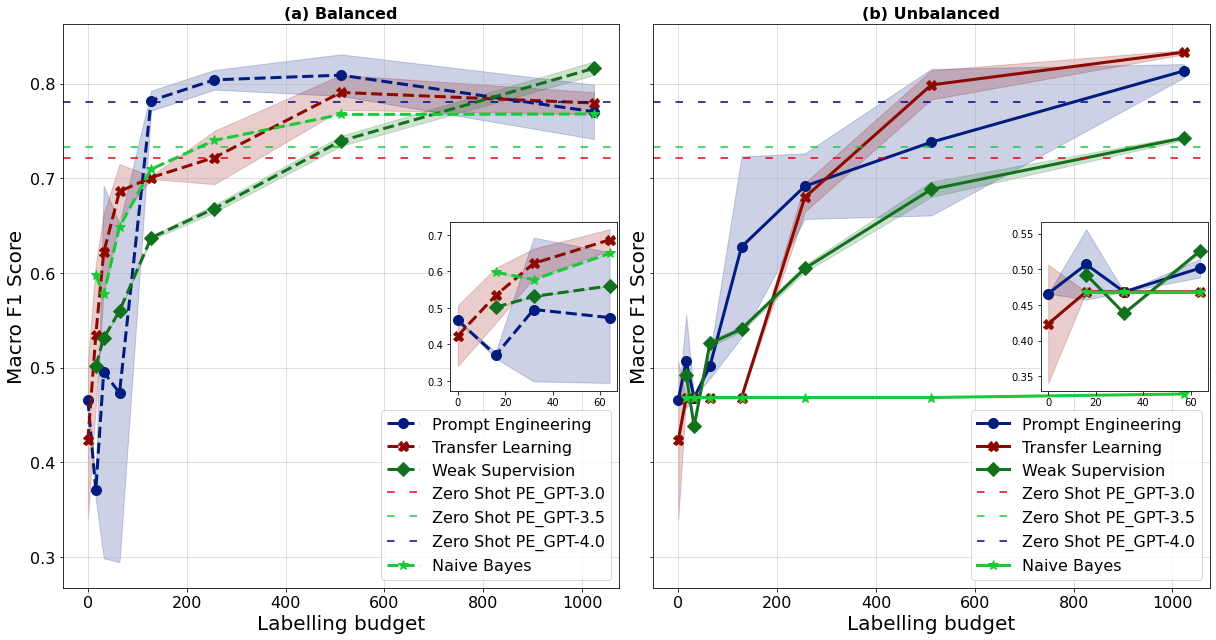

In [19]:
task = 'Binary Abuse'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                     'Zero Shot Prompt Engineering':'GPT-3.0',
                     'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain abuse?'
fixed_prompt_zp = 'Using one word, does the internet comment contain toxic language, Yes or No?'
y_var= 'f1'

# plot_learning_curves('single panel', exp_df, techniques_models, task, y_var,
#                     colors, linestyles, markers, figure_orders,
#                     alpha_mean, min_alpha, threshold, fixed_prompt)

plot_learning_curves_inset('multi panel', exp_df, techniques_models, task, y_var,
                    colors, linestyles, markers, figure_orders,
                    alpha_mean, min_alpha, threshold, fixed_prompt, fixed_prompt_zp)

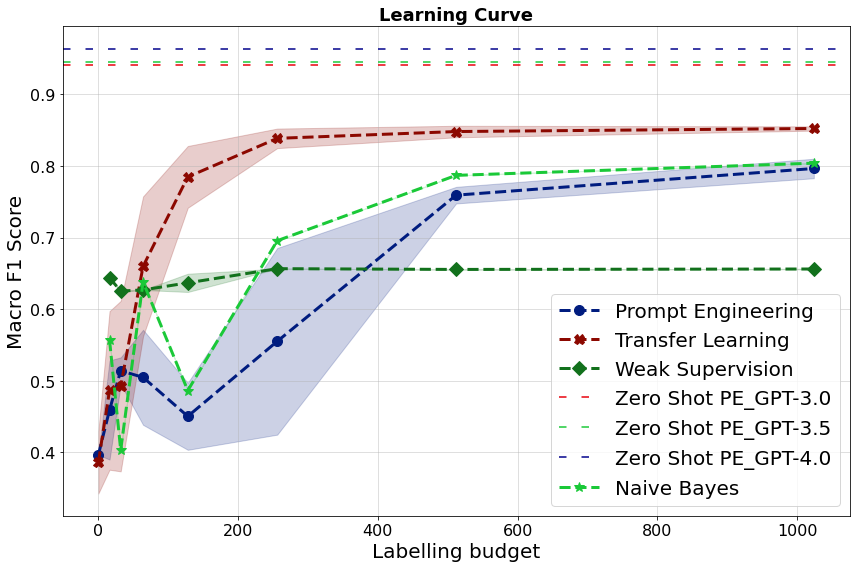

In [20]:
task = 'Binary Movie Sentiment'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                     'Zero Shot Prompt Engineering':'GPT-3.0',
                    'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain negative sentiment?'
fixed_prompt_zp = 'Using one word, does the movie review contain negative sentiment, Yes or No?'
y_var= 'f1'

plot_learning_curves('single panel', exp_df, techniques_models, task, y_var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'lower right', fixed_prompt, fixed_prompt_zp)

### All Techniques (training time)

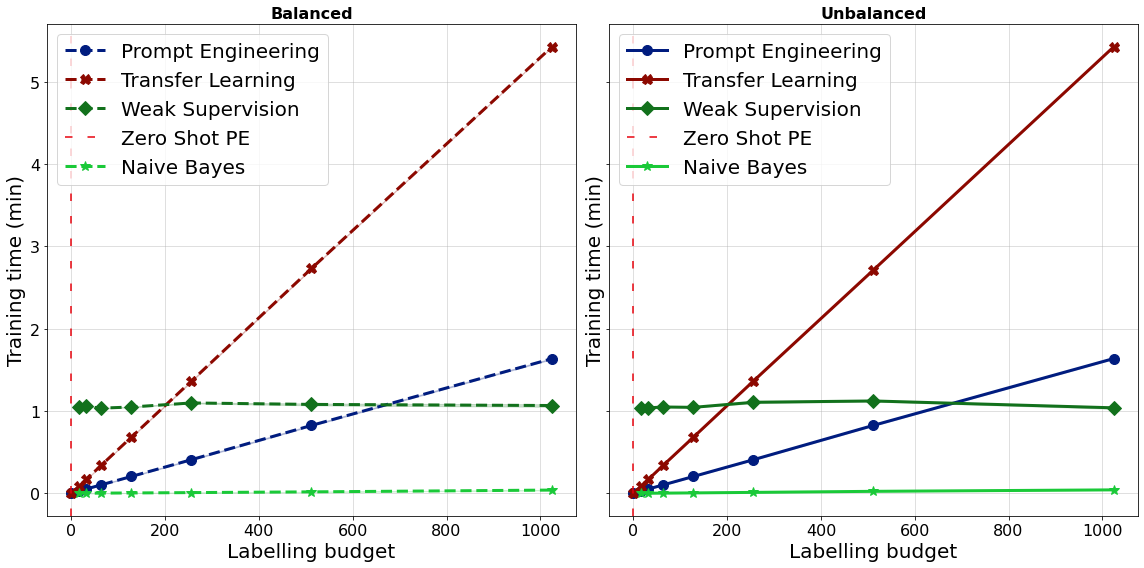

In [22]:
task = 'Binary Abuse'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                     'Zero Shot Prompt Engineering':'GPT-3.0',
                     'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain abuse?'
fixed_prompt_zp = 'Using one word, does the movie review contain negative sentiment, Yes or No?'
var= 'train_runtime'

plot_learning_curves('multi panel', exp_df, techniques_models, task, var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'upper left', fixed_prompt, fixed_prompt_zp)

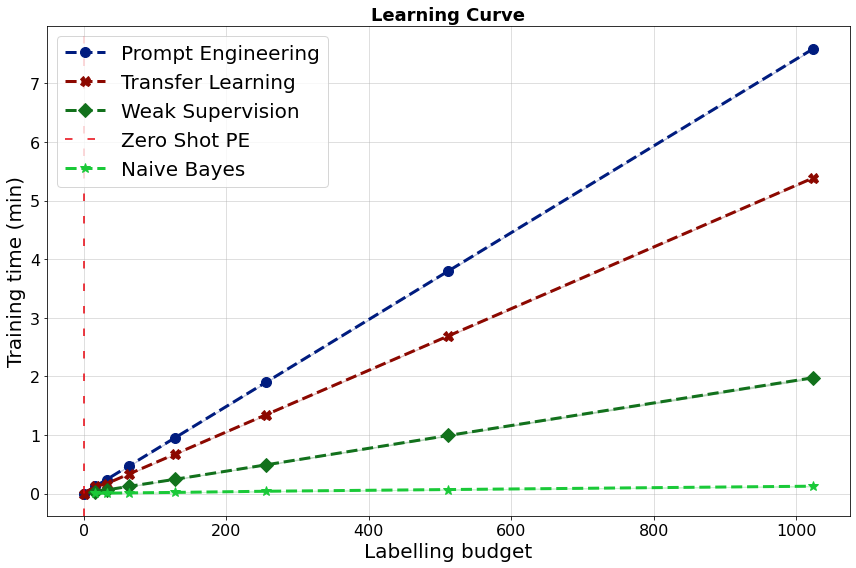

In [23]:
task = 'Binary Movie Sentiment'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel',
                      'Zero Shot Prompt Engineering':'GPT-3.0',
                      'Naive Bayes':'Naive Bayes'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain negative sentiment?'
fixed_prompt_zp = 'Using one word, does the movie review contain negative sentiment, Yes or No?'
var= 'train_runtime'

plot_learning_curves('single panel', exp_df, techniques_models, task, var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'upper left', fixed_prompt, fixed_prompt_zp)

# Plot Single Technique By Split Var


In [116]:
#TODO: Have version of graph where you can specify a lower n-train cutoff


def plot_learning_curves_by_split_var_multi(PLOT_TYPE, exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold):

    plot_df = exp_df[(exp_df['technique']==technique)]
    fixed_var_dict = base_variable_values[technique]
    for col, fixed_v in fixed_var_dict.items():
        if col!=split_var:
            plot_df = plot_df[plot_df[col].isin(fixed_v)]
    values = plot_df[split_var].unique()
    task = base_variable_values[technique]['task'][0]


    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        single_ax.set_title(f'{technique} by {split_var.capitalize()}', fontweight = 'semibold', fontsize = 18)
    else:
        multi_fig, multi_ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
        # plt.suptitle(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
    if task == 'Binary Movie Sentiment':
        balanced_type = [[False, "Balanced"]]
    else:
        balanced_type = [[True, "Balanced"], [False, "Unbalanced"]]
    for i,val in enumerate(values):
        for j, balanced in enumerate(balanced_type):
            # Subset dataframe
            line_df = plot_df[(plot_df[split_var]==val)&(plot_df['balanced_train']==balanced[0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                label = f'{val} ({balanced[1]})'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(f'{figure_orders[j]} {balanced[1]}', fontweight = 'semibold', fontsize = 16)
                label = val
                color = colors[i][0]

            # Plot contents
            ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
            if split_var == 'template':
                ax.legend(loc='lower right', ncol = 1, fontsize = 16)
            else:
                ax.legend(loc='lower right', ncol = 1, fontsize = 20)
            alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
            ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
            # Plot features
            ax.grid(alpha=0.5)

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Training points', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)

    plt.tight_layout()
    plt.show()

In [117]:
# SET FIXED VALUES
base_variable_values = {'Prompt Engineering':{'task': ['Binary Abuse'],
                        'template': ['Prompt 2: Does this text contain abuse?',
                                    'Prompt 2: Does this text contain negative sentiment?',
                                     ],
                        'model':['DistilBERT']},

                        'Transfer Learning':{'task': ['Binary Abuse'],
                        'model':['DistilBERT']},

                        'Weak Supervision':{'task': ['Binary Abuse'],
                        'model':['LabelModel']},


}

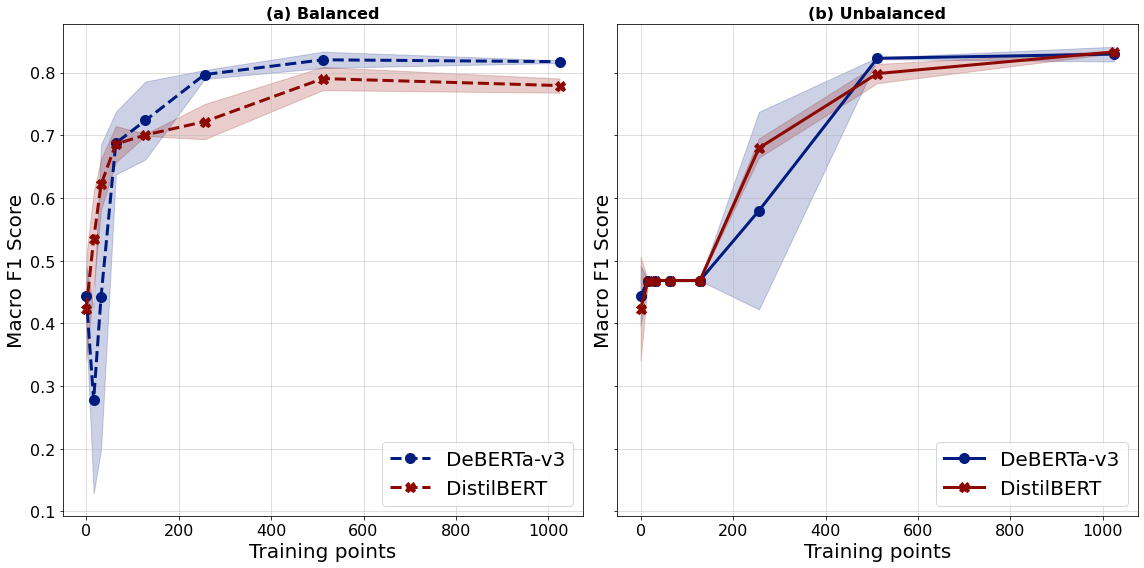

In [118]:
split_var = 'model'
y_var = 'f1'
technique = 'Transfer Learning'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

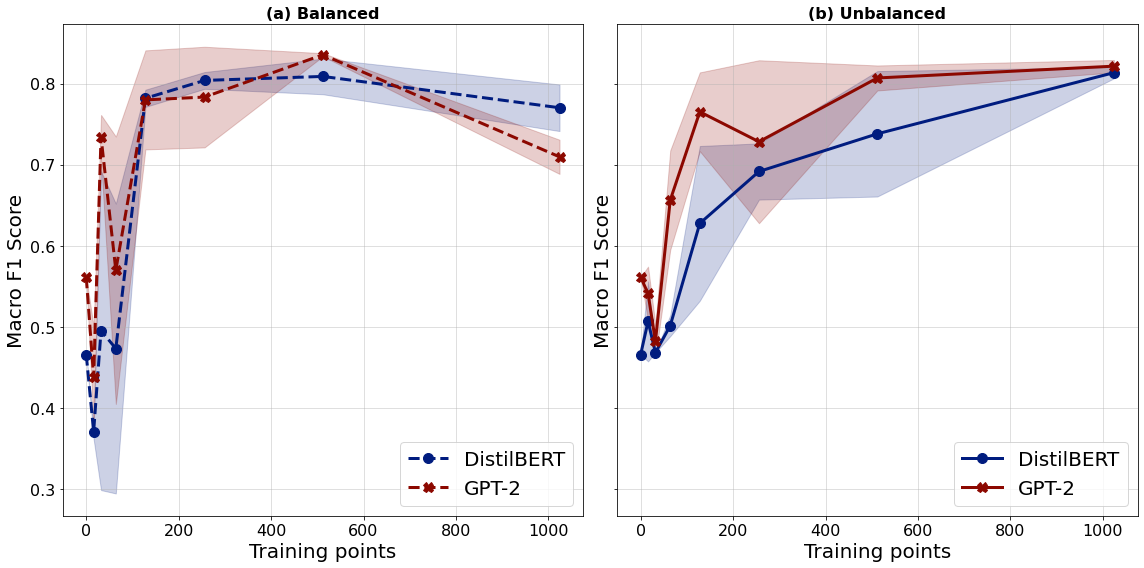

In [119]:
split_var = 'model'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

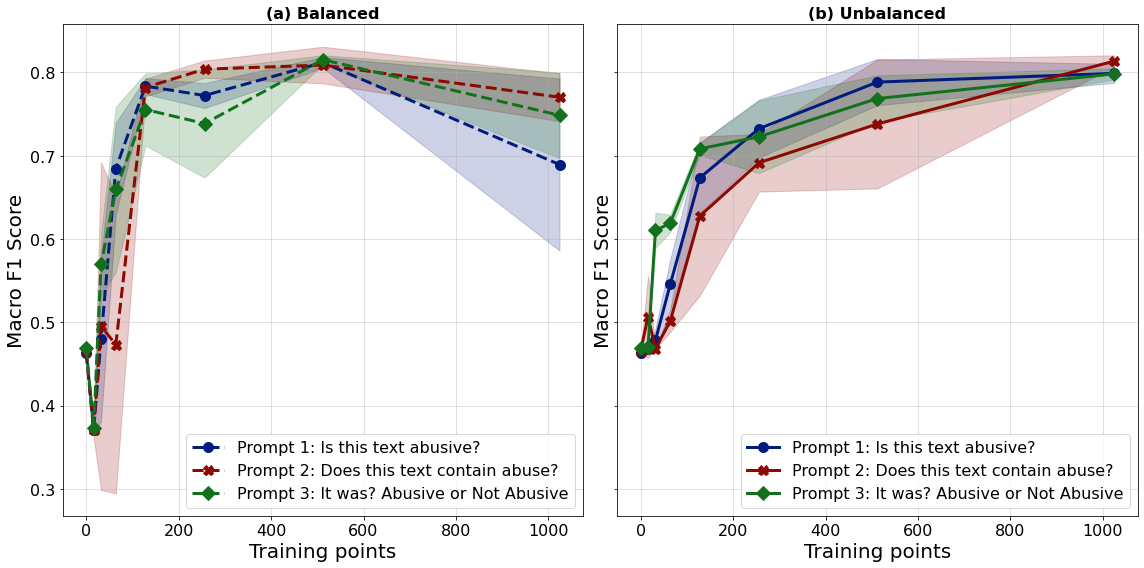

In [120]:
split_var = 'template'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

In [121]:
# SET FIXED VALUES
base_variable_values = {'Prompt Engineering':{'task': ['Binary Movie Sentiment'],
                        'template': ['Prompt 2: Does this text contain negative sentiment?',
                                     ],
                        'model':['DistilBERT']},

                        'Transfer Learning':{'task': ['Binary Movie Sentiment'],
                        'model':['DistilBERT']},

                        'Weak Supervision':{'task': ['Binary Movie Sentiment'],
                        'model':['LabelModel']},


}

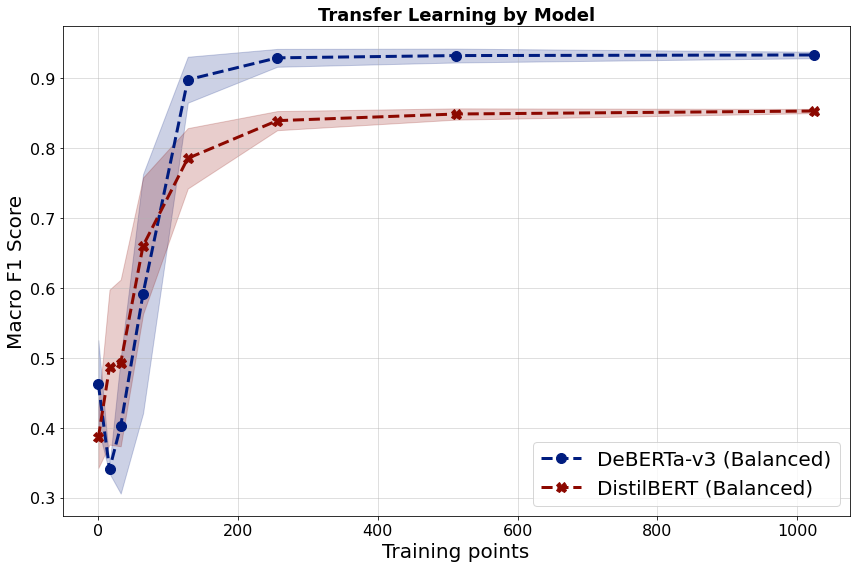

In [122]:
split_var = 'model'
y_var = 'f1'
technique = 'Transfer Learning'

plot_learning_curves_by_split_var_multi('single panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

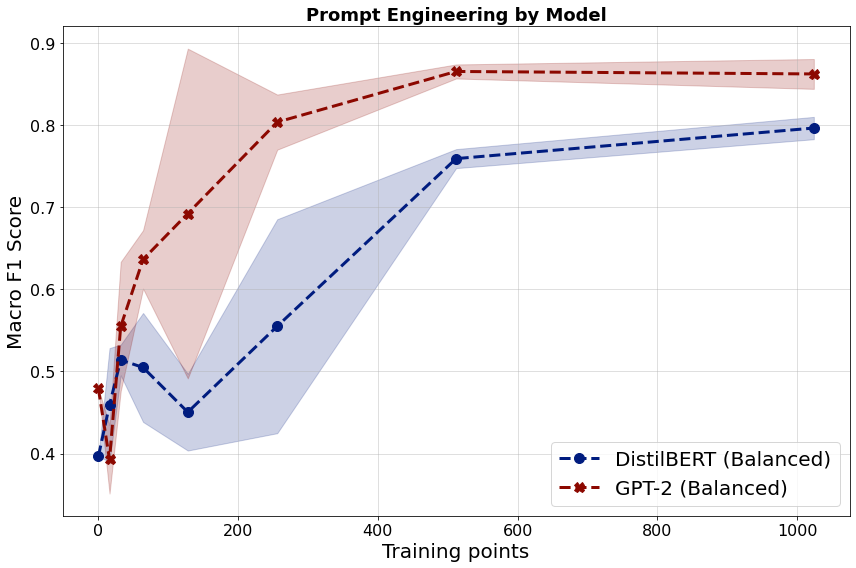

In [123]:
split_var = 'model'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('single panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

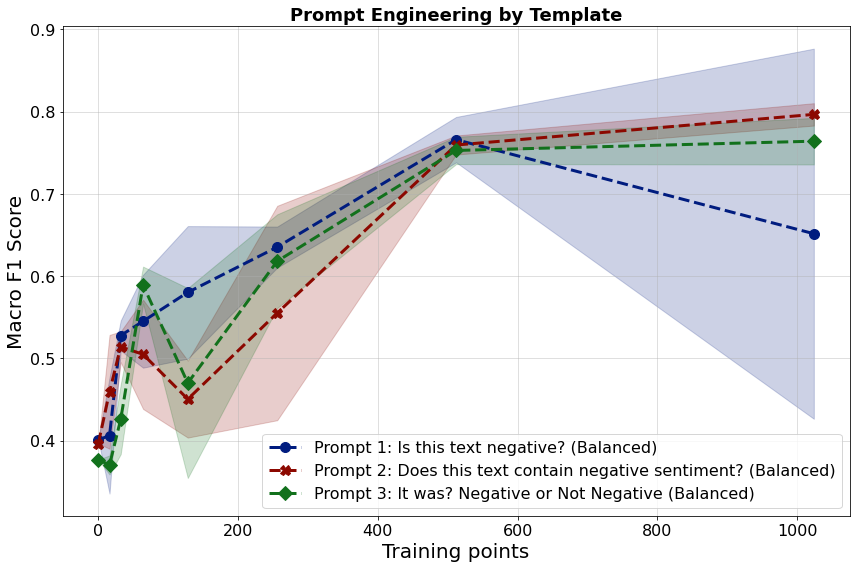

In [124]:
split_var = 'template'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('single panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)